In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt

# CSV-Datei laden
df = pd.read_csv("dawum.de_Bundestag_2025-02-15.csv")

# Datum in datetime umwandeln und Jahr extrahieren
df["Datum"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y")
# df.set_index("Datum", inplace=True)

# NaN-Werte mit 0 ersetzen
df = df.fillna(0)

# Zahlen als float darstellen (mit ',' als Dezimaltrennzeichen)
for col in df.columns[1:]:
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float)

In [11]:
# Nur numerische Spalten extrahieren
df_avg_month_numerics = df.select_dtypes(include=[np.number])

# Sicherstellen, dass jede Zeile 100 % ergibt (normalisieren)
df_avg = df_avg_month_numerics.div(df_avg_month_numerics.sum(axis=1), axis=0) * 100
df_avg

,CDU/CSU,SPD,FDP,Grüne,Linke,AfD,Freie Wähler,BSW,Sonstige
0,38.5,23.5,5.0,10.0,9.0,8.5,0.0,0.0,5.5
1,38.7,23.3,4.6,10.0,9.4,8.3,0.0,0.0,5.7
2,38.6,23.3,4.7,10.0,9.5,8.7,0.0,0.0,5.2
3,37.9,23.8,4.6,10.0,8.8,9.5,0.0,0.0,5.4
4,37.7,24.0,4.8,10.0,8.6,9.7,0.0,0.0,5.2
...,...,...,...,...,...,...,...,...,...
1910,29.6,15.9,4.0,13.3,5.4,20.7,1.8,4.8,4.5
1911,29.5,15.7,4.0,13.5,5.4,20.5,1.8,4.7,4.9
1912,30.1,15.2,4.0,13.5,5.7,20.5,1.4,4.6,5.0
1913,30.3,15.2,4.1,13.4,5.8,20.4,1.4,4.6,4.8


In [12]:
# Gewichtungen für die Regression
weights = np.arange(1, len(df_avg) + 1) ** 3  # Gewichtung für die Regression

# Jahre für die Regression extrahieren
years = df_avg.index.values.reshape(-1, 1)
y_avg = df_avg.values
# Lineares Regressionsmodell erstellen
model = LinearRegression()

# Modell mit den Gewichtungen trainieren
model.fit(years, y_avg, sample_weight=weights)


LinearRegression()

In [13]:
# Vorhersage für das nächste Jahr
next_year = np.array([[years.max() + 1]])  # Vorhersage für das nächste Jahr
y_pred = model.predict(next_year)

# Sicherstellen, dass die Summe 100 % bleibt
y_pred = y_pred / y_pred.sum(axis=1, keepdims=True) * 100

# Vorhersage in DataFrame umwandeln
result_pie = pd.DataFrame([y_pred[0]], columns=df.columns.drop("Datum"))
result_pie

,CDU/CSU,SPD,FDP,Grüne,Linke,AfD,Freie Wähler,BSW,Sonstige
0,30.21682,16.008095,4.269302,12.54136,2.893781,19.697911,2.238642,5.328858,6.805231


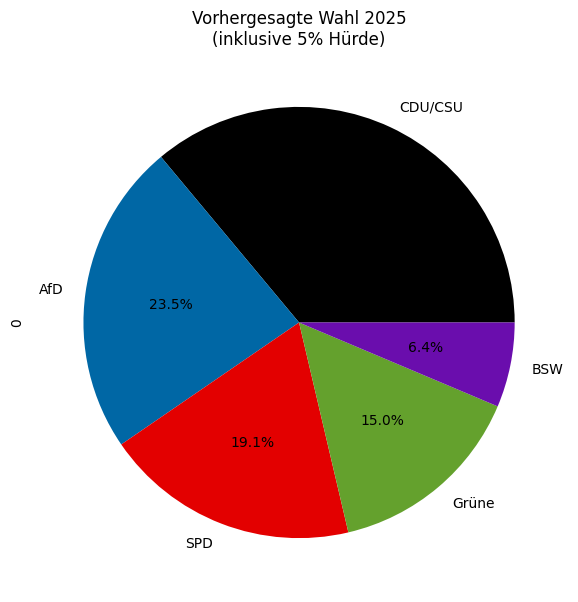

,CDU/CSU,AfD,SPD,Grüne,BSW
0,36.061251,23.507812,19.104325,14.967066,6.359547


In [14]:
# Sortieren und Werte für die Visualisierung anpassen
result_pie_sorted = result_pie.iloc[0].sort_values(ascending=False)
result_pie_sorted = result_pie_sorted[result_pie_sorted >= 5].drop("Sonstige")
result_pie_sorted = result_pie_sorted / result_pie_sorted.sum() * 100

# Farbzuweisung für die Parteien
colors = {
    "CDU/CSU": '#000000',  # Schwarz für CDU/CSU
    "SPD":  '#E30000',      # Rot für SPD
    "FDP":  '#FFED00',      # Gelb für FDP
    "Grüne": '#64A12D',     # Grün für Grüne
    "Linke": '#BE1E2D',     # Dunkelrot für Die Linke
    "AfD": '#0067A5',       # Blau für AfD
    "Freie Wähler": '#FFCC00',  # Gelb für Freie Wähler
    "BSW": '#6A0DAD',       # Lila für BSW
    "Sonstige": '#D3D3D3'   # Grau für Sonstige
}

sorted_colors = [colors[kat] for kat in result_pie_sorted.index]

# Diagramm plotten
result_pie_sorted.plot(kind='pie', labels=result_pie_sorted.index, autopct='%1.1f%%', legend=False, figsize=(7, 7),  colors=sorted_colors)
plt.title("Vorhergesagte Wahl 2025\n(inklusive 5% Hürde)")
plt.show()
pd.DataFrame(result_pie_sorted).T